In [1]:
#1. Preprocesado de informacion clasica
#En esta seccion se cargara la base de datos
#Al mismo tiempo que se limpiara, eliminando las caracteristicas que no aporten informacion
#Tambien se convertiran a numericas dichas caracteristicas que sean cualitativas
#Finalmente se normalizara

In [2]:
#1.1 Librerias

import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
#1.2 Se carga el dataset

sys.path.insert(0, '..')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
#1.3 Se limpia el dataset eliminando caracteristicas poco significativas

train = train.dropna(subset=["Embarked"])
train = train.drop("Cabin", axis=1) 
mean = train["Age"].mean()
train["Age"] = train["Age"].fillna(mean)
train = train.drop("PassengerId", axis=1)
train = train.drop("Name", axis=1) 
train = train.drop("Ticket", axis=1)

In [5]:
#1.4 Se convierte a numericas las caracteristicas cualitativas

le = LabelEncoder()
for col in ['Sex', 'Embarked']:
    le.fit(train[col])
    train[col] = le.transform(train[col])

In [6]:
#1.5 Se normaliza el dataset

scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)

In [7]:
#Se procede a guardar el dataset limpio en el repositorio
input_data = train[:, 1:8]
labels = train[:, 0]

train_input, test_input, train_labels, test_labels = train_test_split(
    input_data, labels, test_size =0.2)

#One-hot encoded
#Para utilizar el clasificador vqc el formato de los labels debe ser one-hot
#En este caso la salida se clasifica en 2 grupos 
#El tripulante sobrevive (1,0) el tripulante muere (0,1)

train_aux=[]
test_aux=[]

for i in train_labels:
    if i==1:
        train_aux.append([1,0])
    else:
        train_aux.append([0,1])
        
for i in test_labels:
    if i==1:
        test_aux.append([1,0])
    else:
        test_aux.append([0,1])

train_labels=np.array(train_aux)
test_labels=np.array(test_aux)
        
with open('data/train.npy', 'wb') as f:
    np.save(f, train_input)
    np.save(f, train_labels)

with open('data/test.npy', 'wb') as f:
    np.save(f, test_input)
    np.save(f, test_labels)

In [8]:
#2. Clasificador cuantico VQC

In [9]:
#2.1 Librerias

from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit_machine_learning.algorithms import VQC
from IPython.display import clear_output
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

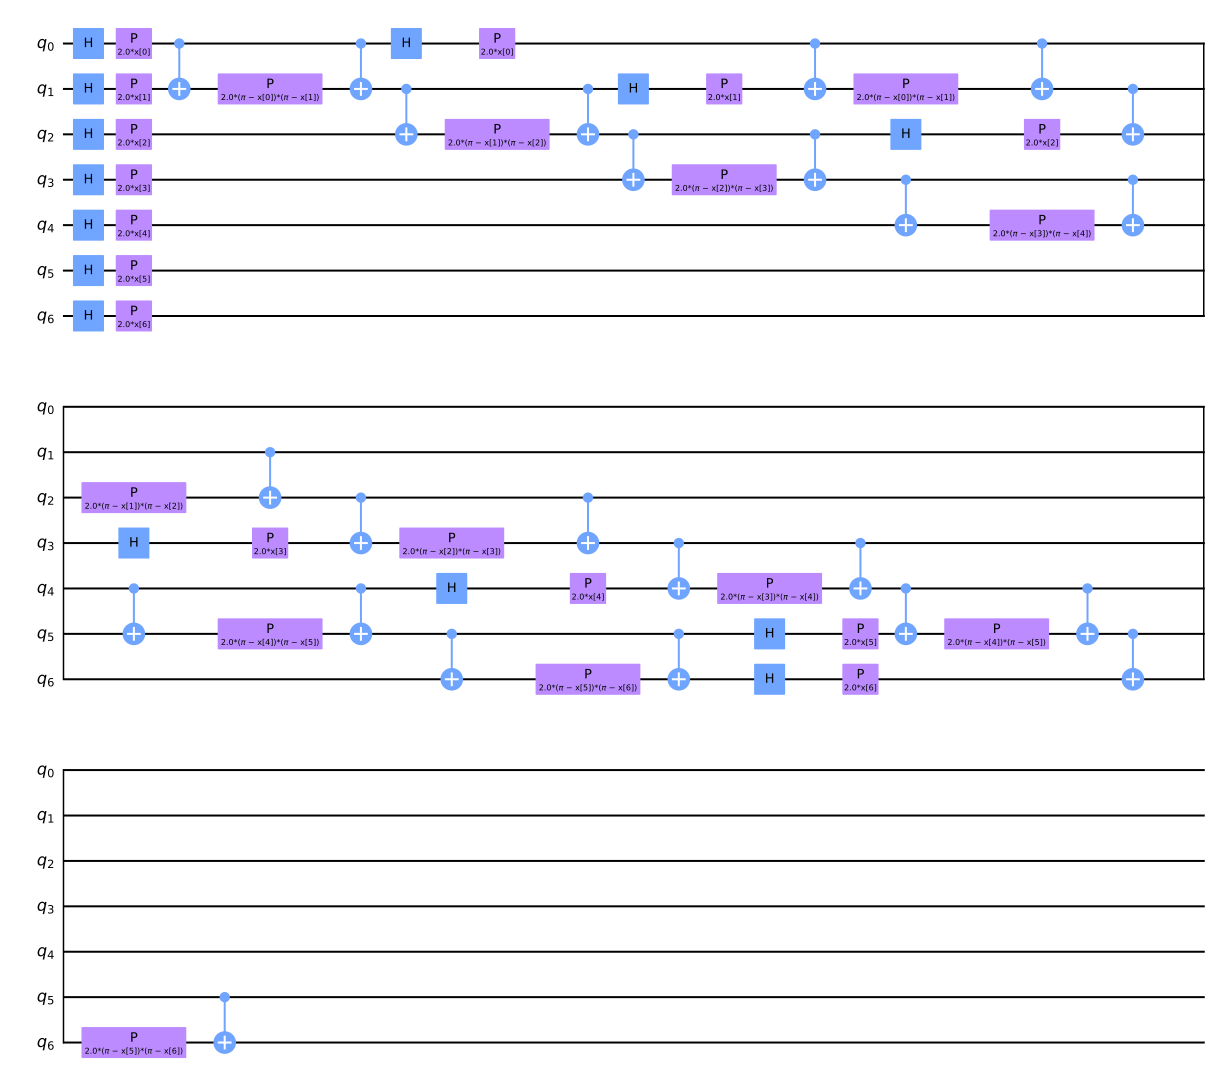

In [10]:
#2.2 Generacion del featuremap
repCfm=2
feature_dim=len(train_input[1])

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=repCfm, entanglement="linear")
display(feature_map.decompose().draw('mpl'))

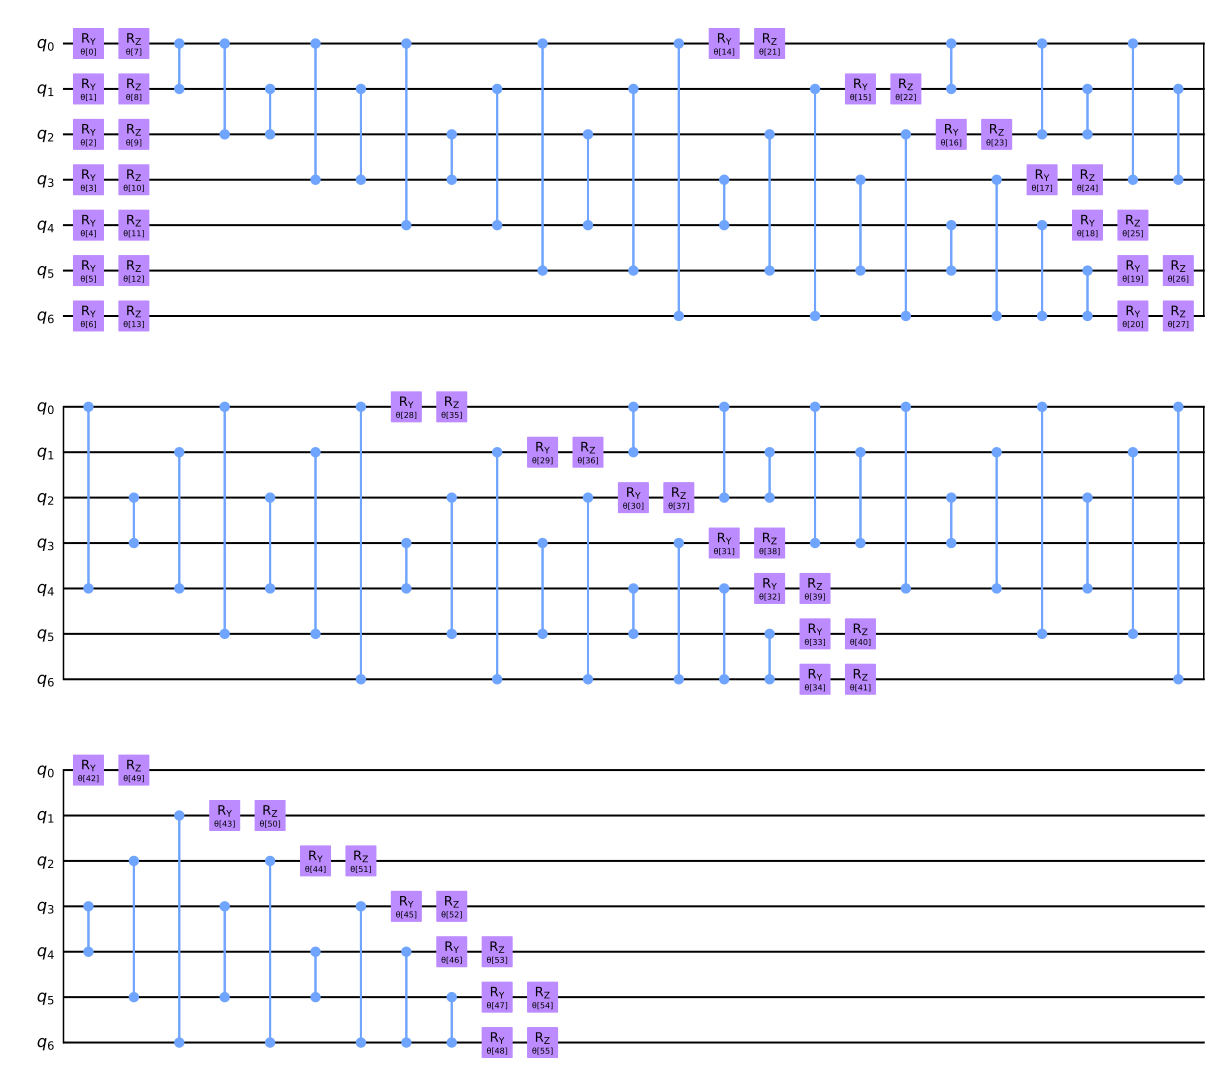

In [11]:
#2.3 Generacion del VC (Variational Circuit)
repCvc=3

ansatz = TwoLocal(feature_map.num_qubits, ['ry', 'rz'], 'cz', reps=repCvc)
display(ansatz.decompose().draw('mpl'))

In [12]:
#2.4 Algunas definiciones

#Esta funcion grafica un punto en tiempo real cada vez que la funcion .fit() es llamada
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

#Se instancia el entorno de ejecucion
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), 
                                   shots=1024)

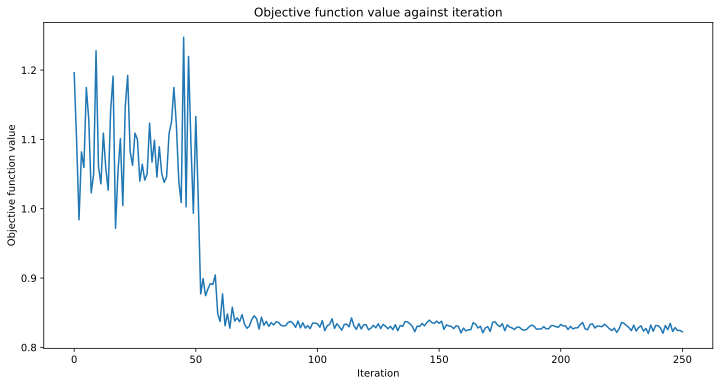

In [13]:
#2.5 Se define el VQC y se ejecuta el entrenamiento

vqc = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=SPSA(maxiter=100),
          quantum_instance=quantum_instance,
          callback=callback_graph
         )

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
vqc.fit(train_input, train_labels)
plt.rcParams["figure.figsize"] = (6, 4)

In [14]:
score = vqc.score(test_input, test_labels)
print(f"The information level is: {score:0.2f}")

The information level is: 0.63
